In [10]:
# !pip install gym

In [12]:
# pip install mineral

In [27]:
import gym
import numpy as np

In [14]:
import matplotlib.pyplot as plt
import time

In [15]:
# env = gym.make('CartPole-v0')

In [16]:
# Checking Breakout env

In [17]:
from gym.envs.registration import register

try:

    register(
        id='FrozenLakeNotSlippery-v0', # make sure this is a custom name!
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery': False},
        max_episode_steps=100,
        reward_threshold=.8196, # optimum = .8196
    )
except:
    print('You probably ran this cell twice, accidentally trying to register a new env with the same id twice.')
    print("Either change the id, or just continue, knowing your id was already registered")


In [18]:
env = gym.make("FrozenLakeNotSlippery-v0")  # Load FrozenLake
env.reset()  # Reset to initial state
for _ in range(5):
    env.render()  # Render on the screen
    action = env.action_space.sample()  # chose a random action
    env.step(action)  # Perform random action on the environment
env.close()  # dont forget to close the environment


SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG


In [19]:
### Manually Play the Environment

# OPTIONAL: Not visually pleasing to see a list, let's clear the output of the cell before writing the new state. For Jupyter Notebook users use the code shown in the cell below, for .py script use:**

import os
os.system('cls')


0

In [20]:
from IPython.display import clear_output
env = gym.make("FrozenLakeNotSlippery-v0")  # Load FrozenLake
observation = env.reset()  # Reset to initial state
for epsiode in range(4):
    print(observation)
    env.render()  # Render on the screen
    time.sleep(0.2)
    clear_output(wait=True)
    action = env.action_space.sample()  # chose a random action
    observation, reward, done, info = env.step(action)  # Perform random action on the environment

env.close()  # dont forget to close the environment

1
  (Up)
SFFF
FHFH
FFFH
HFFG


Let us take a look at the possible actions.
You can find them here: https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

As we can see, there is just 1 observation, a single digit representing the current location, for a 4by4 "lake":

    0    1   2  3
    4    5   6  7
    8    9  10  11
    12  13  14  15

and four actions:

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

The next cell contains code to play the game manually - Feel free to try it out by using the left and right arrow key.

### Very simple code to manually play. This will break if you don't use asdw() function correctly.




# Hyperparameters

**The Q-Learning update functions will require hyperparameters. we'll define them here. Often the best place to choose a good starting value is reading publications or through experimentation. Unfortunately, its very difficult to give general advice, as most environments are radically different to each other, and often hyperparameter tuning is required.**

**Q-Learning Equation Parameters: https://en.wikipedia.org/wiki/Q-learning**

In [21]:

# It is common to leave Hyperparameters in ALL CAPS to easily locate them

EPOCHS=20000  # number of epochs/episodes to train for
ALPHA = 0.8 # aka the learning rate
GAMMA = 0.95 # aka the discount rate
# MAX_EPISODES = 100  # optional, also defined in env setup above

**Exploration vs. Exploitation Parameters**

Basically how fast do we reduce epsilon. Reduce too fast, agent won't have enough time to learn. Reduce too slow, you're wasting time picking random actions. Key here is that these value help balance exploration (random choice) versus explotation (always picking what works for that Q(s,a). It's a tough balance!

In [22]:
# Exploration vs. Exploitation parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.001             # Exponential decay rate for exploration prob


## Now it is time to dive into the training / Q-Table update methodology.<br />
First we will define some functions needed for training phase

* epsilon_greedy_action_selection: Is used to implement the epsilon greedy action selection routine.
* compute_next_q_value: Computes the next Q-Values according to the formula from the lecture
* reduce_epsilon: Reduces the $\epsilon$ used for the epsilon greedy algorithm

**FUNCTION TO SELECT AN ACTION**

If we simply always select the argmax() qtable value during training, we'll most likely get stuck in an explotation loop, so we'll use a random value to randomly select an action from time to time, helping the model explore , rather than exploit.


In [23]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    '''
    Returns an action for the agent. Note how it uses a random number to decide on
    exploration versus explotation trade-off.
    '''
    random_number = np.random.random()

    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        # Action row for a particular state
        state_row = q_table[discrete_state,:]
        # Index of highest action for state
        # Recall action is mapped to index (e.g. 0=LEFT, 1=DOWN, etc..)
        action = np.argmax(state_row)

    # EXPLORATION, USE A RANDOM ACTION
    else:
        # Return a random 0,1,2,3 action
        action = env.action_space.sample()

    return action


**FUNCTION FOR Q_VALUE COMPUTATION**

**Here we have our main Q-Learning update equation, note how it takes in the old q-value, the next optimal q value, along with our current reward, and then updates the next q value accordingly.**

In [24]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):

    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)



**FUNCTION TO REDUCE EPSILON**

**As training continues, we need to balance explotation versus exploration, we want ot make sure our agent doesn't get trapped in a cycle going from an F square to another F Square back and forth. We also don't want our agent permanently choosing random values. We'll use the function below to try to balance this.**



In [25]:
def reduce_epsilon(epsilon,epoch):

    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

In [32]:
action_size = env.action_space.n
state_size = env.observation_space.n

In [33]:
q_table = np.zeros([state_size, action_size])
total_reward = 0
epsilon = 1

In [43]:
rewards = []

# Play 20k games
for episode in range(EPOCHS):
    # Reset the environment
    state = env.reset()
    done = False
    total_rewards = 0
    
    while not done:
        action = epsilon_greedy_action_selection(epsilon,q_table, state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        
        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[state,action]  

        # Get the next optimal Q-Value
        next_optimal_q_value = np.max(q_table[new_state, :])  

        # Compute next q value
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)   

        # Update Q Table
        q_table[state,action] = next_q

        
        
        total_rewards = total_rewards + reward
        
        # Our new state is state
        state = new_state

        
    episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode) 
    rewards.append(total_rewards)


env.close()


In [44]:
np.cumsum(rewards)

array([1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.8682e+04, 1.8683e+04,
       1.8684e+04])

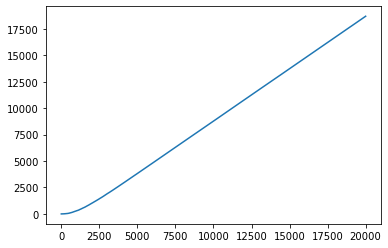

In [45]:
plt.plot(range(EPOCHS),np.cumsum(rewards))

